# Kaggle TGS Salt Identification Challenge EDA

This notebook provides a simple exploration of the dataset for the Kaggle TGS Salt Identification Challenge

## Setup

In [1]:
# Standard python packages
import os
import sys

# Other package imports
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tqdm import tqdm_notebook, tnrange

import seaborn as sns
sns.set_style("white")

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


Setup some global settings and configuration

In [2]:
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
data_folder = os.path.join(project_root, 'data')
data_folder_raw = os.path.join(data_folder, 'raw')
src_folder = os.path.join(project_root, 'src')

train_path = os.path.join(data_folder_raw, 'train')
train_images_path = os.path.join(train_path, 'images')
train_masks_path = os.path.join(train_path, 'masks')
train_file = os.path.join(data_folder_raw, 'train.csv')

test_path = os.path.join(data_folder_raw, 'test')
test_images_path = os.path.join(test_path, 'images')

depth_file = os.path.join(data_folder_raw, 'depths.csv')

# Other parameters / shared functions
img_size_ori = 101

This notebook uses the shared package however first we need to ensure it is available (otherwise you get an error about the module not being found). You can either run setup.py as discussed in the readme to install the package or modify the path to include the src folder.

In [3]:
# Explicitly set path so don't need to run setup.py - if we have multiple copies of 
# the code we would otherwise need to setup a seperate environment for each to
# ensure the code pointers are correct.
sys.path.insert(0, src_folder)

from examplepackage import examplemodule

## Train / test files
Look at the train and test fils that contains image id's along with a mask of salt regions

In [4]:
train_df = pd.read_csv(train_file, index_col="id", usecols=[0])
depths_df = pd.read_csv(depth_file, index_col="id")
train_df = train_df.join(depths_df)

train_model_output = pd.read_csv(depth_file, index_col="id")

test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [5]:
train_df.head()

z
id             
575d24d81d  843
a266a2a9df  794
75efad62c1  468
34e51dba6a  727
4875705fb0  797

In [6]:
test_df.head()

z
id             
353e010b7b  264
5439dbbddf  557
71bab9f311  846
52551f7a80  610
512d8d9997  577

In [63]:
train_df.shape

(4000, 5)

In [64]:
test_df.shape

(18000, 2)

## Basic Visualisation of Images / Masks

In [7]:
def read_image(data_id):    
    filename = os.path.join(train_images_path, "{}.png".format(data_id))
    image = cv2.imread(filename)   
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_image
    
def read_mask(data_id, is_train=True):
    filename = os.path.join(train_masks_path, "{}.png".format(data_id))
    image = cv2.imread(filename)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_image
    
def plot_image_mask(data_id):
    image = read_image(data_id)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    mask = read_mask(data_id)
    
    green_image = np.zeros(image.shape, image.dtype)
    green_image[:,:] = (0, 255, 0)
    green_mask = cv2.bitwise_and(green_image, green_image, mask=mask)
    
    combined_image = np.zeros(image.shape, image.dtype)
    cv2.addWeighted(green_mask, 0.2, image, 1, 0, combined_image)
    
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(image, cmap="gray")
    axarr[1].imshow(mask, cmap="gray")
    axarr[2].imshow(combined_image, cmap="gray")
    axarr[0].grid()
    axarr[1].grid()
    axarr[2].grid()
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask') 
    axarr[2].set_title('Combined')
    plt.show()

Information about a single image

(101, 101)


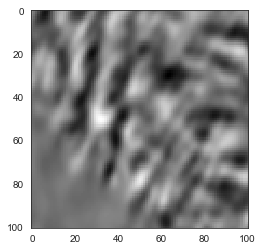

In [8]:
image = read_image("34e51dba6a")
print(image.shape)
plt.imshow(image, cmap="gray")

Information about a mask

(101, 101)


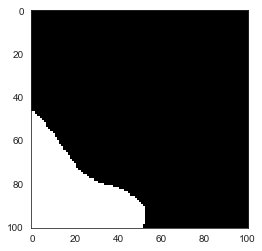

In [9]:
mask = read_mask("34e51dba6a")
print(mask.shape)
plt.imshow(mask, cmap="gray")

Combined plot showing the image with the mask overlayed. Here we can see that there are examples without salt, as you can see by the masks that are entirely dark.

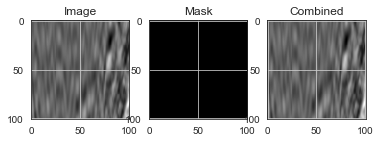

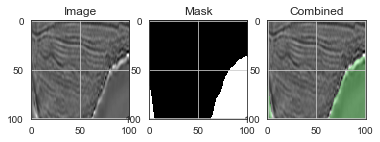

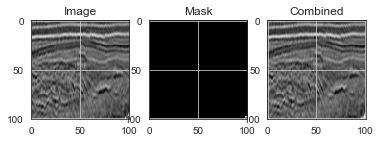

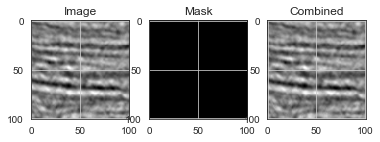

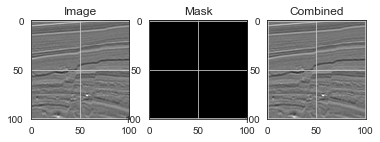

In [10]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
for j, img_name in enumerate(ids):
    img = plot_image_mask(img_name)

## Read images and masks
Load the images and masks into the DataFrame and divide the pixel values by 255.

In [11]:
train_df["images"] = [np.array(load_img(os.path.join(train_images_path, "{}.png").format(idx), color_mode="grayscale")) / 255 for idx in tqdm_notebook(train_df.index)]

In [12]:
train_df["masks"] = [np.array(load_img(os.path.join(train_masks_path, "{}.png").format(idx), color_mode="grayscale")) / 255 for idx in tqdm_notebook(train_df.index)]

In [57]:
test_df["images"] = [np.array(load_img(os.path.join(test_images_path, "{}.png").format(idx), color_mode="grayscale")) / 255 for idx in tqdm_notebook(test_df.index)]

c:\applications\miniconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Calculating the salt coverage and salt coverage classes
Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only. Plotting the distribution of coverages and coverage classes, and the class against the raw coverage.

In [60]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [14]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

Text(0.5,0,'Coverage class')

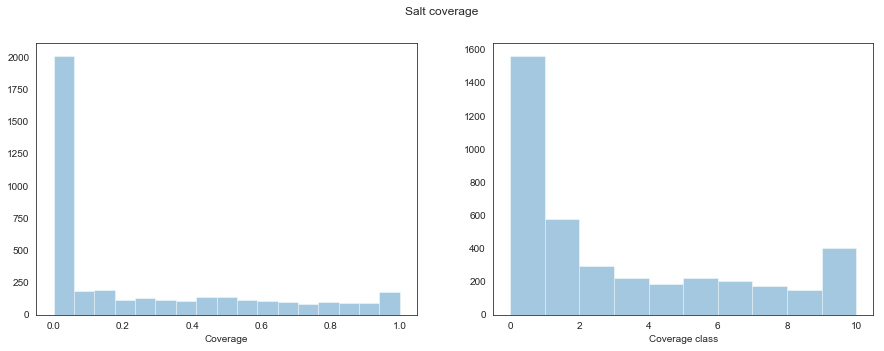

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

# Setup some additional data structures
The below are standard numpy arrays and are for ease of use with later plotting

In [61]:
x_train_sorted_by_coverage=np.array(train_df.sort_values(by='coverage').images.tolist()).reshape(-1, 101, 101)
x_train_sorted_by_z=np.array(train_df.sort_values(by='z').images.tolist()).reshape(-1, 101, 101)
y_train_sorted_by_coverage=np.array(train_df.sort_values(by='coverage').masks.tolist()).reshape(-1, 101, 101)
y_train_sorted_by_z=np.array(train_df.sort_values(by='z').masks.tolist()).reshape(-1, 101, 101)

x_test_sorted_by_z=np.array(test_df.sort_values(by='z').images.tolist()).reshape(-1, 101, 101)

## Plot the depth distributions
Separatelty plot the depth distributions for the training and the testing data.

Text(0.5,1,'Depth distribution')

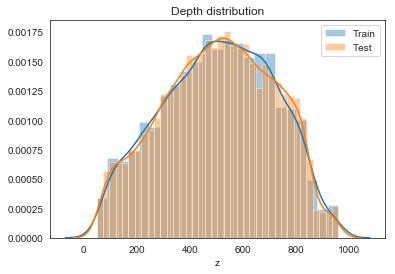

In [16]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

## Check depth / coverage correlation
Is there a correlation between the size of the salt mask and the depth?

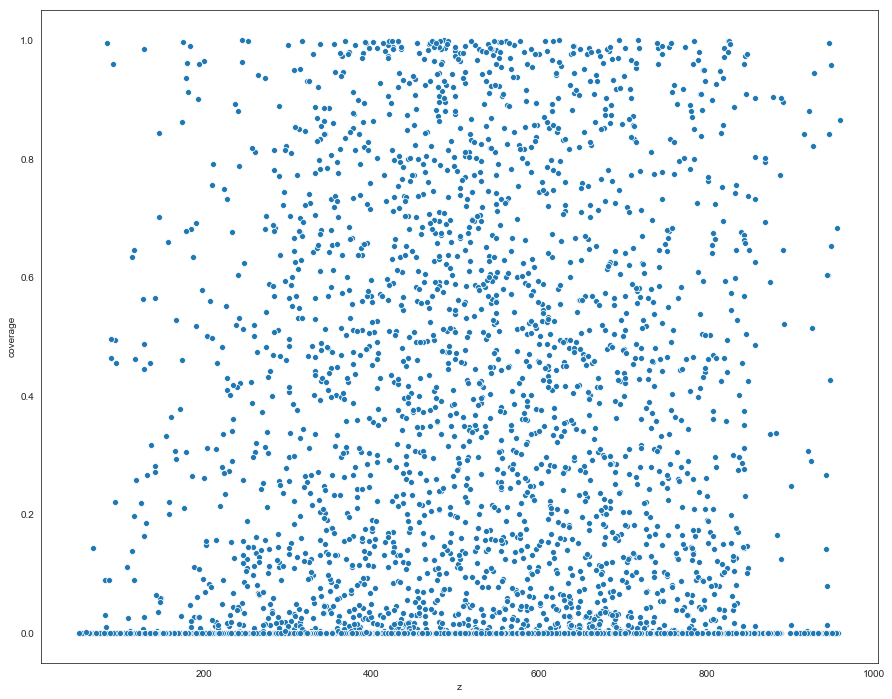

In [17]:
plt.figure(figsize=(15,12))
sns.scatterplot(x="z", y="coverage", data=train_df)

In [18]:
np.corrcoef(train_df.z , train_df.coverage)[0,1]

0.10361580365557439

From teh above it would seem that there is little correlation between depth and coverage. Note that we can't exclude correlation between depth and other features though (e.g. structure), but don't test that here!

## More Example Images

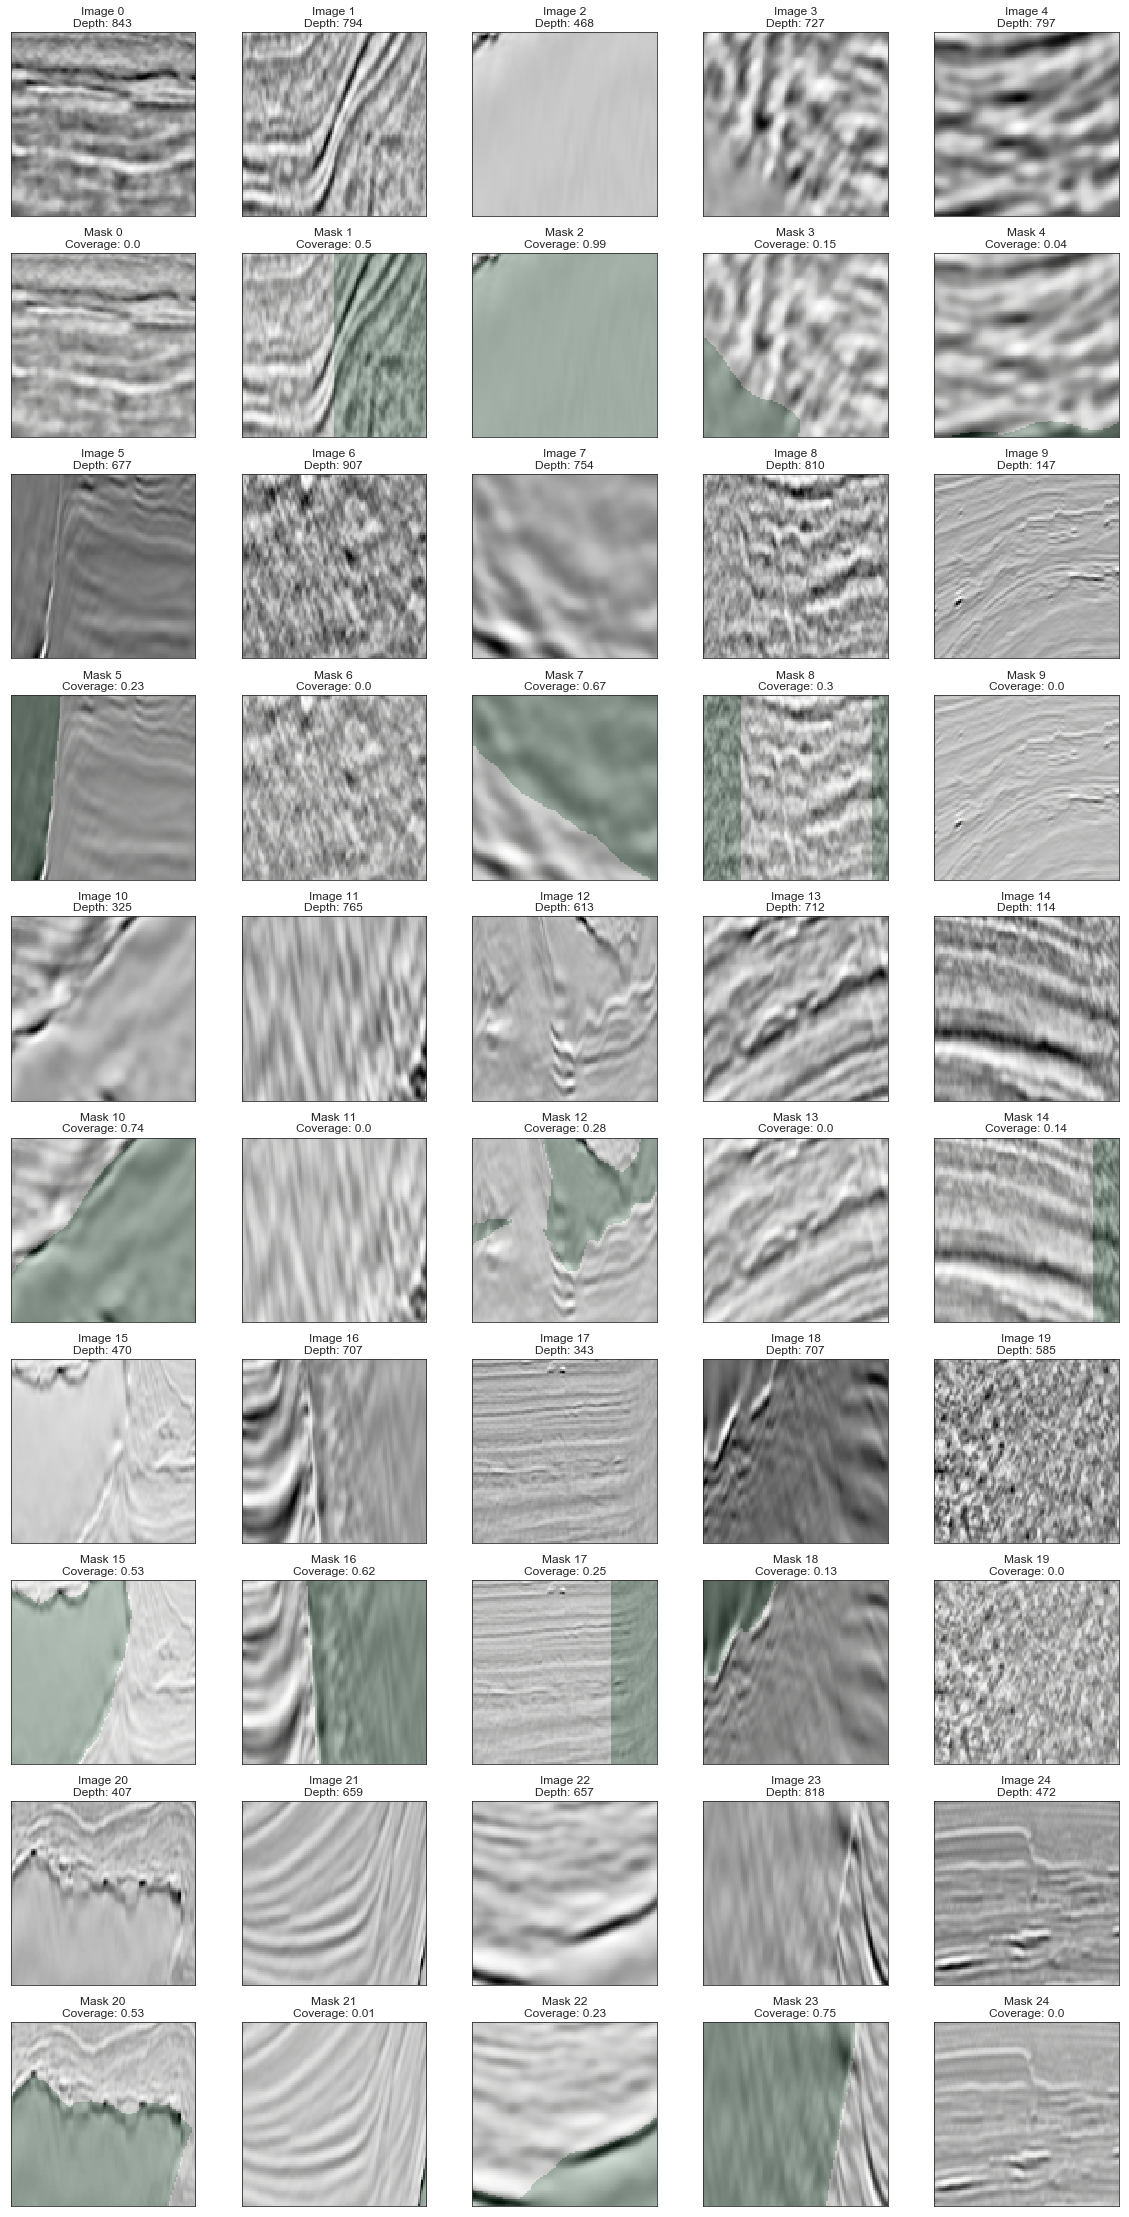

In [19]:
max_images = 25
grid_width = 5
grid_height = int(max_images / grid_width)*2
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*4, grid_height*4))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax_image = axs[int(i / grid_width)*2, i % grid_width]
    ax_image.imshow(img, cmap="Greys")
    ax_image.set_title("Image {0}\nDepth: {1}".format(i, train_df.loc[idx].z))
    ax_image.set_yticklabels([])
    ax_image.set_xticklabels([])
    ax_mask = axs[int(i / grid_width)*2+1, i % grid_width]
    ax_mask.imshow(img, cmap="Greys")
    ax_mask.imshow(mask, alpha=0.2, cmap="Greens")
    ax_mask.set_title("Mask {0}\nCoverage: {1}".format(i,  round(train_df.loc[idx].coverage, 2)))
    ax_mask.set_yticklabels([])
    ax_mask.set_xticklabels([])

Another plot of multiple images

(1009, 1009)


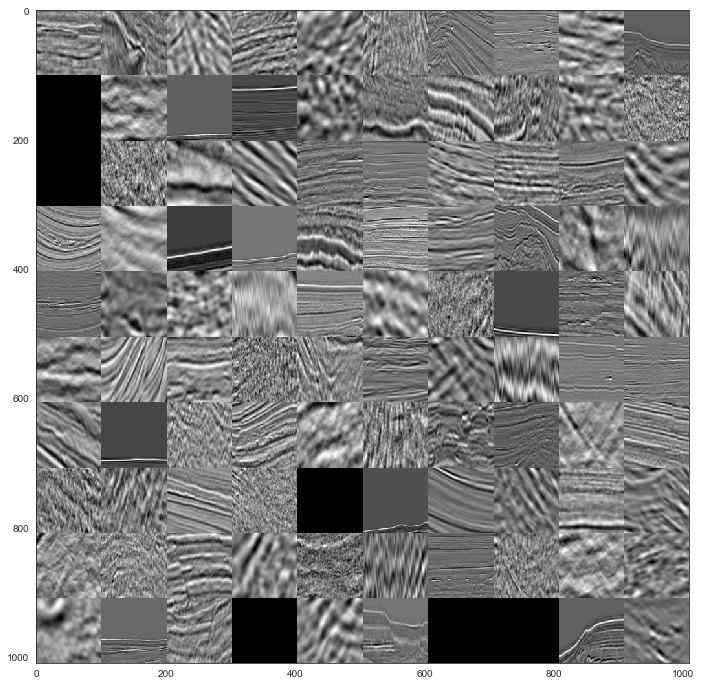

In [38]:
plt.figure(figsize=(12,12))

def imgtile(imgs,tile_w):
    assert imgs.shape[0]%tile_w==0,"'imgs' cannot divide by 'th'."
    r=imgs.reshape((-1,tile_w)+imgs.shape[1:])
    return np.hstack(np.hstack(r))

#usage
tiled = imgtile(x_train_sorted_by_coverage[:100],10)[:-1, :-1]
plt.imshow(tiled, cmap="gray")
print(tiled.shape)

# All Data as Thumbnails Sorted by Depth
Training data first (images and masks)

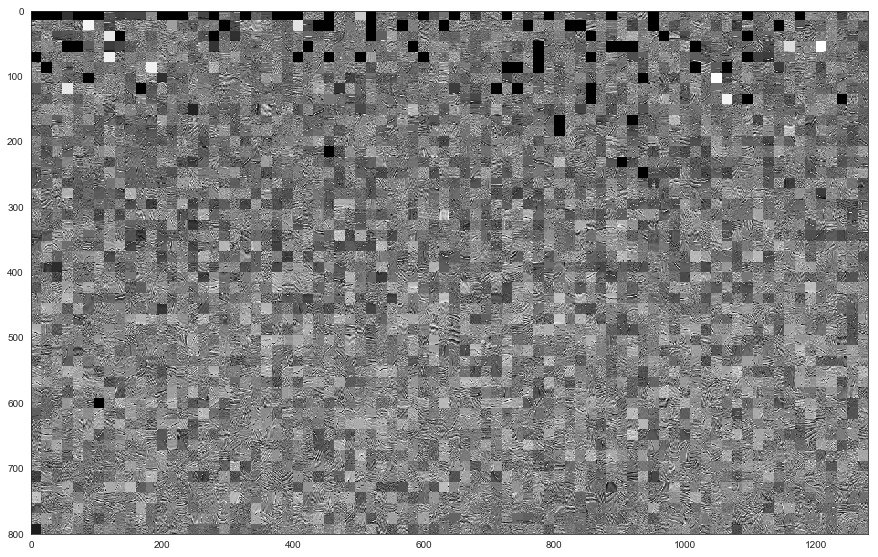

In [42]:
plt.figure(figsize=(15,15))
all=imgtile(x_train_sorted_by_z,80)
all = (cv2.resize( all, (80*16,50*16), interpolation=cv2.INTER_LINEAR ))
plt.imshow(all, cmap="gray")

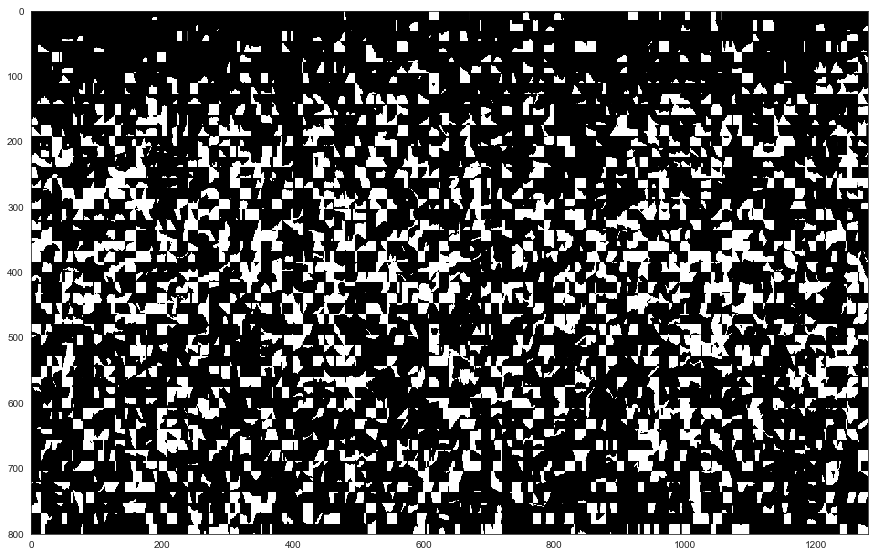

In [41]:
plt.figure(figsize=(15,15))
all=imgtile(y_train_sorted_by_z,80)
all = (cv2.resize( all, (80*16,50*16), interpolation=cv2.INTER_LINEAR ))
plt.imshow(all, cmap="gray")

Now show test data. There definately appear to be some suspicious (blank) images in the data set. We will verify this later.

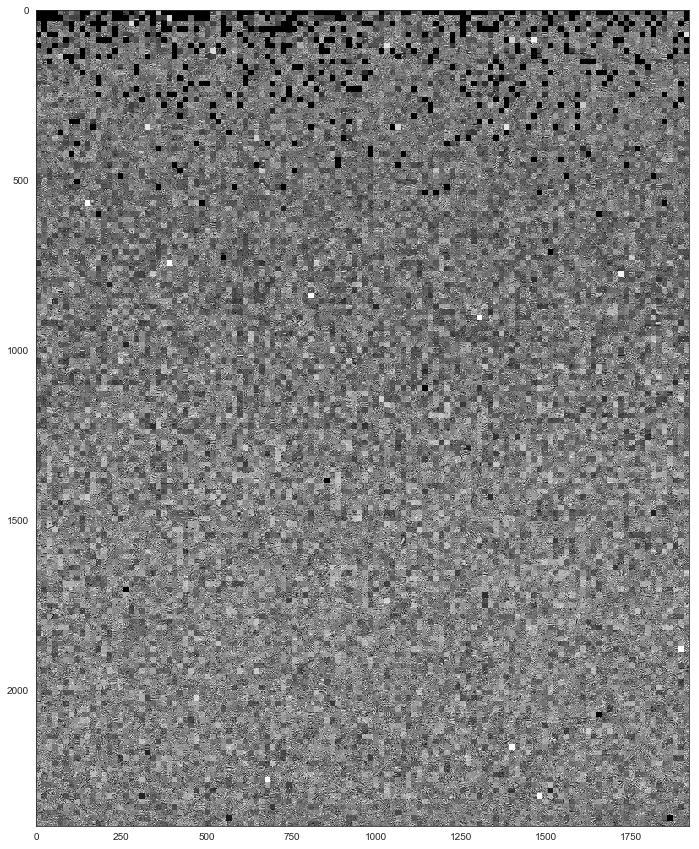

In [66]:
plt.figure(figsize=(15,15))
all=imgtile(x_test_sorted_by_z,120)
all = (cv2.resize( all, (120*16,150*16), interpolation=cv2.INTER_LINEAR ))
plt.imshow(all, cmap="gray")

## All Data as Thumbnails Sorted by Coverage
Display all training data as thumbnails sorted by coverage. 

Training data images and masks (we don't have coverage for the test data as we need to predict the mask which is what was used for claculating this for the training set).

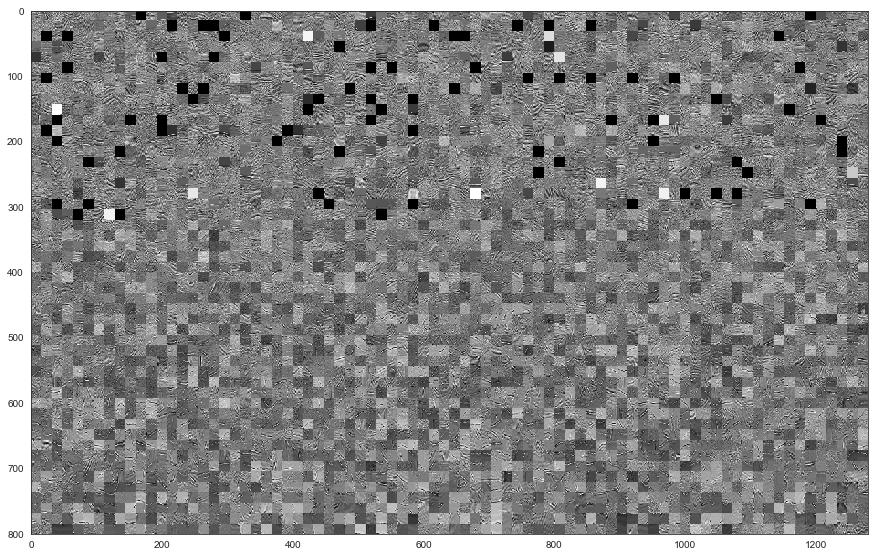

In [44]:
plt.figure(figsize=(15,15))
all=imgtile(x_train_sorted_by_coverage,80)
all = (cv2.resize( all, (80*16,50*16), interpolation=cv2.INTER_LINEAR ))
plt.imshow(all, cmap="gray")

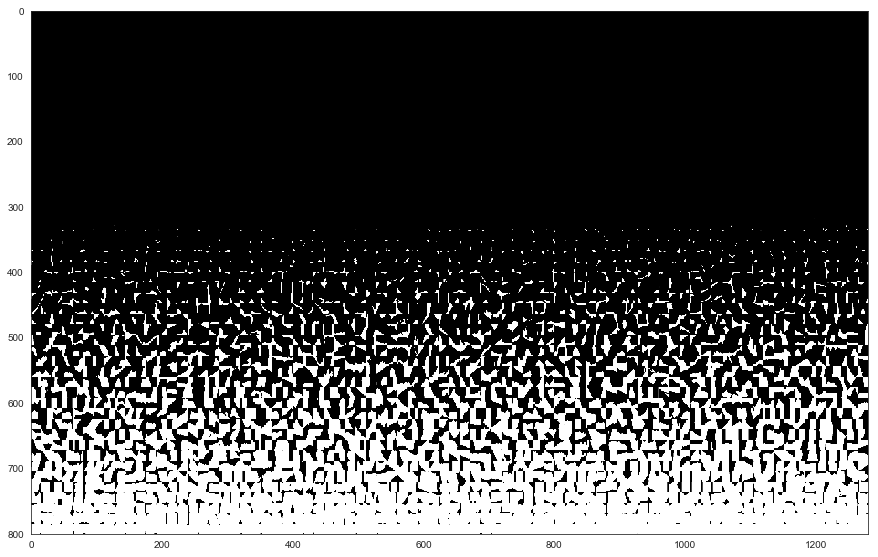

In [45]:
plt.figure(figsize=(15,15))
all=imgtile(y_train_sorted_by_coverage,80)
all = (cv2.resize( all, (80*16,50*16), interpolation=cv2.INTER_LINEAR ))
plt.imshow(all, cmap="gray")

# Pad the Edges by Mirroring
Convolutional networks can struggle with the corners and edges of images. For that reason we can try mirroring the data. This might also give additional data to work with. Before doing such mirroring we need to check that it actually makes sense to do this.

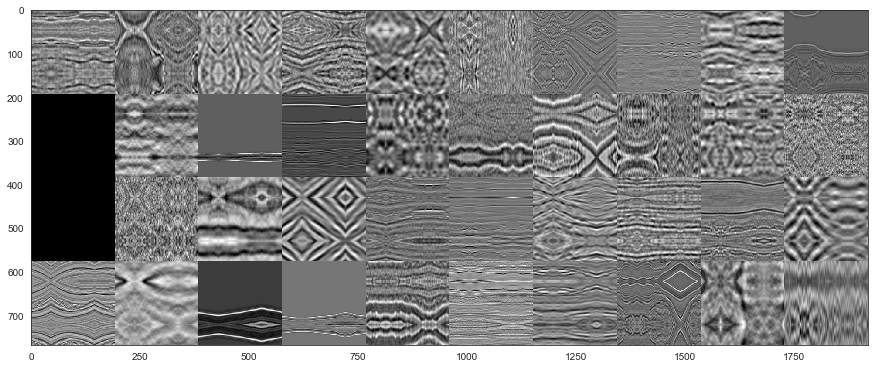

In [55]:
def create_padded(imgs,dst_hw,odd_mirror=True):
    imgs_hw=imgs.shape[1:3]
    assert((np.array(imgs_hw)<=np.array(dst_hw)).all())
    #calc
    pad_t, pad_l = int((dst_hw[0]-imgs_hw[0])/2), int((dst_hw[1]-imgs_hw[1])/2)
    pad_b, pad_r = dst_hw[0]-imgs_hw[0]-pad_t, dst_hw[1]-imgs_hw[1]-pad_l
    #copy
    ret=np.zeros((imgs.shape[0],)+dst_hw)
    ret[:,pad_t:pad_t+imgs_hw[0],pad_l:pad_l+imgs_hw[1]]=imgs[:,:,:]
    # use below for 3d array
    # ret=np.zeros((imgs.shape[0],)+dst_hw+(imgs.shape[3],))
    # ret[:,pad_t:pad_t+imgs_hw[0],pad_l:pad_l+imgs_hw[1],:]=imgs[:,:,:,:]
    #pad
    ofs=1 if odd_mirror else 0
    ret[:,:pad_t,:]=ret[:,pad_t*2+ofs:pad_t+ofs:-1,:]
    ret[:,-pad_b:,:]=ret[:,-pad_b-1-ofs:-pad_b*2-1-ofs:-1,:]
    ret[:,:,:pad_l]=ret[:,:,pad_l*2+ofs:pad_l+ofs:-1]
    ret[:,:,-pad_r:]=ret[:,:,-pad_r-1-ofs:-pad_r*2-1-ofs:-1]    
    # use below for 3d array
    # ret[:,:pad_t,:,:]=ret[:,pad_t*2+ofs:pad_t+ofs:-1,:,:]
    # ret[:,-pad_b:,:,:]=ret[:,-pad_b-1-ofs:-pad_b*2-1-ofs:-1,:,:]
    # ret[:,:,:pad_l,:]=ret[:,:,pad_l*2+ofs:pad_l+ofs:-1,:]
    # ret[:,:,-pad_r:,:]=ret[:,:,-pad_r-1-ofs:-pad_r*2-1-ofs:-1,:]    
    return ret

plt.figure(figsize=(15,15))
x_train_padded=create_padded(x_train_sorted_by_coverage,(192,192))
y_train_padded=create_padded(y_train_sorted_by_coverage,(192,192))
plt.imshow(imgtile(x_train_padded[:40], 10), cmap="gray")
#cvshow(imgtile(x_train_padded[:40],10))

## Check For Bad Images
From the plot above it looked like there might be some bad images. WWe define these as ones with no change (typically either fully black, or fully white).

We can either rely on the model capturing this from possible similar situations in the training set, or predict these with zero or full coverage based upon what the status-quo for similar images in the training set is.

In [83]:
def check_bad_images(df):
    badimgs = 0
    all_black = 0
    all_white = 0
    for i,f in enumerate(df.index.values):
        if(df.iloc[i].images.std()==0):
            # print(f)
            badimgs+=1
        if(df.iloc[i].images.sum()==0):
            # print(f)
            all_black+=1
        if(df.iloc[i].images.min()>=1):
            # print(f)
            all_white+=1

    print('Bad images',badimgs)
    print('Percentage Bad Images',badimgs/18000)
    print('All black',all_black)
    print('All white',all_white)

In [84]:
check_bad_images(train_df)

Bad images 80
Percentage Bad Images 0.0044444444444444444
All black 80
All white 0


In [85]:
check_bad_images(test_df)

Bad images 430
Percentage Bad Images 0.02388888888888889
All black 430
All white 0


## Appendix 1 - Environment Configuration

In [18]:
print (os.getcwd())
print (sys.version)
print (sys.executable)
print (sys.path)

D:\Development\DataScience\Learning\Kaggle TGS Salt Identification Challenge\notebooks\eda
3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
c:\applications\miniconda3\envs\tensorflow-gpu\python.exe
['D:\\Development\\DataScience\\Learning\\Kaggle TGS Salt Identification Challenge\\src', '', 'c:\\applications\\miniconda3\\envs\\tensorflow-gpu\\python36.zip', 'c:\\applications\\miniconda3\\envs\\tensorflow-gpu\\DLLs', 'c:\\applications\\miniconda3\\envs\\tensorflow-gpu\\lib', 'c:\\applications\\miniconda3\\envs\\tensorflow-gpu', 'c:\\applications\\miniconda3\\envs\\tensorflow-gpu\\lib\\site-packages', 'c:\\applications\\miniconda3\\envs\\tensorflow-gpu\\lib\\site-packages\\object_detection-0.1-py3.6.egg', 'c:\\applications\\miniconda3\\envs\\tensorflow-gpu\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\mark_\\.ipython']


## Appendix 2 - Automated Tests

In [19]:
# Run tests within notebook
f_path = os.getcwd()
os.chdir(os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir)))

# Run pytest from the repository root
!pytest

os.chdir(f_path)

============================= test session starts =============================
platform win32 -- Python 3.6.2, pytest-3.2.1, py-1.4.34, pluggy-0.4.0
rootdir: D:\Development\DataScience\Learning\Kaggle TGS Salt Identification Challenge, inifile:
collected 0 items / 3 errors

=================================== ERRORS ====================================
___________________ ERROR collecting tests/test_notebook.py ___________________
ImportError while importing test module 'D:\Development\DataScience\Learning\Kaggle TGS Salt Identification Challenge\tests\test_notebook.py'.
Hint: make sure your test modules/packages have valid Python names.
Traceback:
tests\test_notebook.py:6: in <module>
    import numpy as np
E   ModuleNotFoundError: No module named 'numpy'
 ERROR collecting tests/examplepackage/examplemodule/test_add_value_to_numpy.py 
ImportError while importing test module 'D:\Development\DataScience\Learning\Kaggle TGS Salt Identification Challenge\tests\examplepackage\examplemodul